## Import libs

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import PCA

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType


import matplotlib.pyplot as plt

import numpy as np

## Criando a sessão Spark

In [2]:
spark = SparkSession.builder.appName('Clustering').getOrCreate()

## Leitura, limpeza dos dados e seleção das features

In [4]:
# leitura dos dados
data_customer=spark.read.csv('dataset/CC GENERAL.csv', header=True, inferSchema=True)
data_customer.printSchema()

root
 |-- CUST_ID: string (nullable = true)
 |-- BALANCE: double (nullable = true)
 |-- BALANCE_FREQUENCY: double (nullable = true)
 |-- PURCHASES: double (nullable = true)
 |-- ONEOFF_PURCHASES: double (nullable = true)
 |-- INSTALLMENTS_PURCHASES: double (nullable = true)
 |-- CASH_ADVANCE: double (nullable = true)
 |-- PURCHASES_FREQUENCY: double (nullable = true)
 |-- ONEOFF_PURCHASES_FREQUENCY: double (nullable = true)
 |-- PURCHASES_INSTALLMENTS_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_TRX: integer (nullable = true)
 |-- PURCHASES_TRX: integer (nullable = true)
 |-- CREDIT_LIMIT: double (nullable = true)
 |-- PAYMENTS: double (nullable = true)
 |-- MINIMUM_PAYMENTS: double (nullable = true)
 |-- PRC_FULL_PAYMENT: double (nullable = true)
 |-- TENURE: integer (nullable = true)



In [5]:
# drop linhas com null values
data_customer=data_customer.na.drop()

In [6]:
# analise das colunas
data_customer.columns

['CUST_ID',
 'BALANCE',
 'BALANCE_FREQUENCY',
 'PURCHASES',
 'ONEOFF_PURCHASES',
 'INSTALLMENTS_PURCHASES',
 'CASH_ADVANCE',
 'PURCHASES_FREQUENCY',
 'ONEOFF_PURCHASES_FREQUENCY',
 'PURCHASES_INSTALLMENTS_FREQUENCY',
 'CASH_ADVANCE_FREQUENCY',
 'CASH_ADVANCE_TRX',
 'PURCHASES_TRX',
 'CREDIT_LIMIT',
 'PAYMENTS',
 'MINIMUM_PAYMENTS',
 'PRC_FULL_PAYMENT',
 'TENURE']

In [7]:
# Criando uma coluna com as features em formato de vetor

inputCols = [
 'BALANCE',
 'BALANCE_FREQUENCY',
 'PURCHASES',
 'ONEOFF_PURCHASES',
 'INSTALLMENTS_PURCHASES',
 'CASH_ADVANCE',
 'PURCHASES_FREQUENCY',
 'ONEOFF_PURCHASES_FREQUENCY',
 'PURCHASES_INSTALLMENTS_FREQUENCY',
 'CASH_ADVANCE_FREQUENCY',
 'CASH_ADVANCE_TRX',
 'PURCHASES_TRX',
 'CREDIT_LIMIT',
 'PAYMENTS',
 'MINIMUM_PAYMENTS',
 'PRC_FULL_PAYMENT',
 'TENURE']

assemble=VectorAssembler(inputCols=inputCols, outputCol='features')
assembled_data=assemble.transform(data_customer)

assembled_data.show(2)

+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+--------------------+
|CUST_ID|    BALANCE|BALANCE_FREQUENCY|PURCHASES|ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|CASH_ADVANCE_TRX|PURCHASES_TRX|CREDIT_LIMIT|   PAYMENTS|MINIMUM_PAYMENTS|PRC_FULL_PAYMENT|TENURE|            features|
+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+--------------------+
| C10001|  40.900749|       

## Normalização dos dados

In [8]:
scale=StandardScaler(inputCol='features',outputCol='standardized')

data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)

data_scale_output.show(2)

+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+--------------------+--------------------+
|CUST_ID|    BALANCE|BALANCE_FREQUENCY|PURCHASES|ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|CASH_ADVANCE_TRX|PURCHASES_TRX|CREDIT_LIMIT|   PAYMENTS|MINIMUM_PAYMENTS|PRC_FULL_PAYMENT|TENURE|            features|        standardized|
+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+--------

In [9]:
data_scale_output.select('standardized').show(10, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|standardized                                                                                                                                                                                                                                                                    |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[0.01951770812869691,3.9393081720608887,0.04402180265591546,0.0,0.10400708755076613,0.0,0.41534603461513986,0.0,0.20933051241176037,0.0,0.0,0.07942664006516227,0.273280762221

In [10]:
vetores = data_scale_output.select('standardized').limit(3).collect()

In [11]:
vetores[0].standardized

DenseVector([0.0195, 3.9393, 0.044, 0.0, 0.104, 0.0, 0.4153, 0.0, 0.2093, 0.0, 0.0, 0.0794, 0.2733, 0.0694, 0.0588, 0.0, 9.1534])

In [12]:
data_scale_output.printSchema()

root
 |-- CUST_ID: string (nullable = true)
 |-- BALANCE: double (nullable = true)
 |-- BALANCE_FREQUENCY: double (nullable = true)
 |-- PURCHASES: double (nullable = true)
 |-- ONEOFF_PURCHASES: double (nullable = true)
 |-- INSTALLMENTS_PURCHASES: double (nullable = true)
 |-- CASH_ADVANCE: double (nullable = true)
 |-- PURCHASES_FREQUENCY: double (nullable = true)
 |-- ONEOFF_PURCHASES_FREQUENCY: double (nullable = true)
 |-- PURCHASES_INSTALLMENTS_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_TRX: integer (nullable = true)
 |-- PURCHASES_TRX: integer (nullable = true)
 |-- CREDIT_LIMIT: double (nullable = true)
 |-- PAYMENTS: double (nullable = true)
 |-- MINIMUM_PAYMENTS: double (nullable = true)
 |-- PRC_FULL_PAYMENT: double (nullable = true)
 |-- TENURE: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- standardized: vector (nullable = true)



## Redução de dimensionalidade - PCA

### Analise do numero de k para o modelo PCA

In [13]:
k = len(inputCols) - 1
k

16

In [14]:
pca_variance = PCA(k=k, inputCol="standardized", outputCol="pca_variance")
pca_variance = pca_variance.fit(data_scale_output)

In [15]:
sum(pca_variance.explainedVariance * 100)

99.99993099540255

In [16]:
np.cumsum(pca_variance.explainedVariance * 100)

array([27.23117698, 47.60548458, 56.5238183 , 64.09742689, 70.37404505,
       76.08683119, 81.00301906, 85.21375333, 88.89545002, 91.97695792,
       94.34076155, 96.11530116, 97.54201143, 98.72067115, 99.72876832,
       99.999931  ])

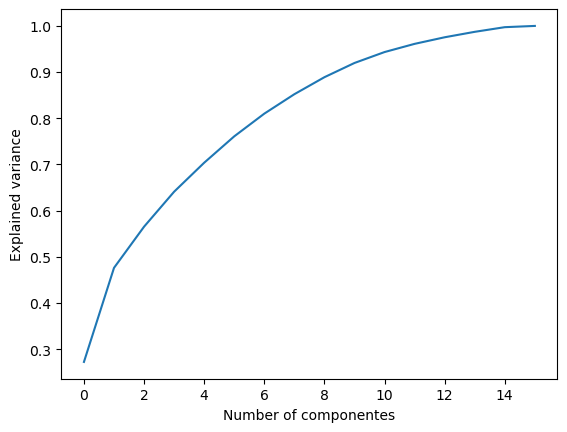

In [17]:
plt.plot(np.cumsum(pca_variance.explainedVariance))
plt.xlabel("Number of componentes")
plt.ylabel("Explained variance")
plt.show()

In [18]:
cumsum = 95
pca_k = len([x for x in np.cumsum(pca_variance.explainedVariance * 100) if x <cumsum])
pca_k

11

### Definindo o modelo PCA com os número de colunas definidas no threahsold

In [19]:
pca = PCA(k=pca_k, inputCol="standardized", outputCol="pca_features")
model = pca.fit(data_scale_output)
data_pca = model.transform(data_scale_output)

In [20]:
data_pca.show(2)

+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+--------------------+--------------------+--------------------+
|CUST_ID|    BALANCE|BALANCE_FREQUENCY|PURCHASES|ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|CASH_ADVANCE_TRX|PURCHASES_TRX|CREDIT_LIMIT|   PAYMENTS|MINIMUM_PAYMENTS|PRC_FULL_PAYMENT|TENURE|            features|        standardized|        pca_features|
+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+-------

In [21]:
data_pca.select('pca_features').show(10, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|pca_features                                                                                                                                                                                                              |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[-1.5035099820874915,0.45051621303073414,-2.629780346046824,-4.44671931446006,0.592321724902648,-6.967999355644114,-3.8906539724797913,1.9405277852549752,-1.2569429705314188,0.19037396510692695,-0.14645460115742526]   |
|[-1.9841966030193872,4.008531954523436,-2.4266958172285706,-3.628403172499894,-0.13082470161752768,-8.0039503530641

## Preparando o modelo de clusterização - kmeans

### Análise de silueta para definir o número de clusters

In [22]:
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')

In [23]:
silhouette_score=[]
range_clusters = range(2,10)

for i in range_clusters:
    KMeans_algo=KMeans(featuresCol='pca_features', k=i)

    KMeans_fit=KMeans_algo.fit(data_pca)

    output=KMeans_fit.transform(data_pca)

    score=evaluator.evaluate(output)

    silhouette_score.append(score)
    
    print("Cluster: {}, Silhouette Score: {}".format(i, score))

Cluster: 2, Silhouette Score: 0.2993970408890385
Cluster: 3, Silhouette Score: 0.27026990900622233
Cluster: 4, Silhouette Score: 0.35230167116201966
Cluster: 5, Silhouette Score: 0.2674109487679287
Cluster: 6, Silhouette Score: 0.29438313259329124
Cluster: 7, Silhouette Score: 0.30560731997387214
Cluster: 8, Silhouette Score: 0.2834813941950764
Cluster: 9, Silhouette Score: 0.29530722663110964


In [24]:
z = zip(range_clusters, silhouette_score)
for c,s in z:
    print("Cluster: {}, Silhouette Score: {}".format(c, s))

Cluster: 2, Silhouette Score: 0.2993970408890385
Cluster: 3, Silhouette Score: 0.27026990900622233
Cluster: 4, Silhouette Score: 0.35230167116201966
Cluster: 5, Silhouette Score: 0.2674109487679287
Cluster: 6, Silhouette Score: 0.29438313259329124
Cluster: 7, Silhouette Score: 0.30560731997387214
Cluster: 8, Silhouette Score: 0.2834813941950764
Cluster: 9, Silhouette Score: 0.29530722663110964


Text(0, 0.5, 'cost')

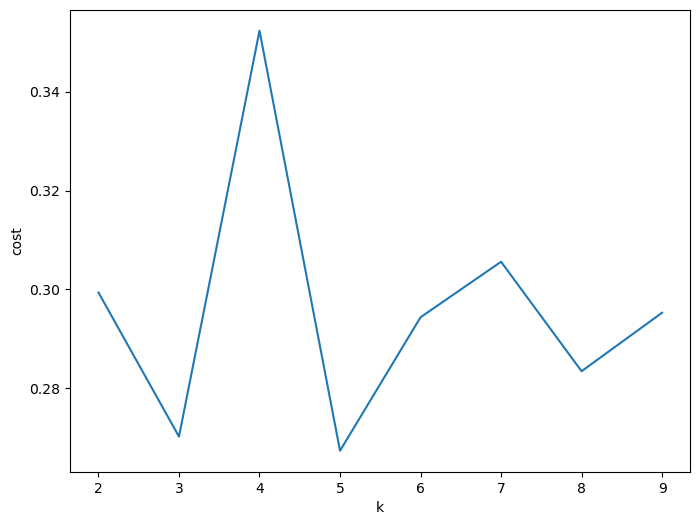

In [25]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [26]:
k_clusters = range_clusters[0] + np.argmax(silhouette_score)
k_clusters

4

### Implementando o cluster com o k definido na análise de silhueta

In [27]:
kmeans = KMeans(featuresCol='pca_features', k=k_clusters)

KMeans_fit = kmeans.fit(data_pca)
data_clusters = KMeans_fit.transform(data_pca)

In [28]:
score=evaluator.evaluate(data_clusters)

print("Number of clusters: {}, Silhouette Score: {}".format(k_clusters, score))

Number of clusters: 4, Silhouette Score: 0.35230167116201966


### Analisando o dataset com clusters

In [29]:
data_clusters.printSchema()

root
 |-- CUST_ID: string (nullable = true)
 |-- BALANCE: double (nullable = true)
 |-- BALANCE_FREQUENCY: double (nullable = true)
 |-- PURCHASES: double (nullable = true)
 |-- ONEOFF_PURCHASES: double (nullable = true)
 |-- INSTALLMENTS_PURCHASES: double (nullable = true)
 |-- CASH_ADVANCE: double (nullable = true)
 |-- PURCHASES_FREQUENCY: double (nullable = true)
 |-- ONEOFF_PURCHASES_FREQUENCY: double (nullable = true)
 |-- PURCHASES_INSTALLMENTS_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_TRX: integer (nullable = true)
 |-- PURCHASES_TRX: integer (nullable = true)
 |-- CREDIT_LIMIT: double (nullable = true)
 |-- PAYMENTS: double (nullable = true)
 |-- MINIMUM_PAYMENTS: double (nullable = true)
 |-- PRC_FULL_PAYMENT: double (nullable = true)
 |-- TENURE: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- standardized: vector (nullable = true)
 |-- pca_features: vector (nullable = true)
 |-- predict

In [30]:
data_clusters.select('prediction').distinct().show()

+----------+
|prediction|
+----------+
|         1|
|         3|
|         2|
|         0|
+----------+



In [31]:
data_clusters.groupby('prediction').count().sort('count').show()

+----------+-----+
|prediction|count|
+----------+-----+
|         2|   39|
|         0| 1468|
|         3| 1826|
|         1| 5303|
+----------+-----+



### Analise 3d dos clusters

In [32]:
pca_3 = PCA(k=3, inputCol="standardized", outputCol="pca3_features")
model_pca_3 = pca_3.fit(data_clusters)
data_pca_3 = model_pca_3.transform(data_clusters)

In [33]:
data_pca_3.printSchema()

root
 |-- CUST_ID: string (nullable = true)
 |-- BALANCE: double (nullable = true)
 |-- BALANCE_FREQUENCY: double (nullable = true)
 |-- PURCHASES: double (nullable = true)
 |-- ONEOFF_PURCHASES: double (nullable = true)
 |-- INSTALLMENTS_PURCHASES: double (nullable = true)
 |-- CASH_ADVANCE: double (nullable = true)
 |-- PURCHASES_FREQUENCY: double (nullable = true)
 |-- ONEOFF_PURCHASES_FREQUENCY: double (nullable = true)
 |-- PURCHASES_INSTALLMENTS_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_TRX: integer (nullable = true)
 |-- PURCHASES_TRX: integer (nullable = true)
 |-- CREDIT_LIMIT: double (nullable = true)
 |-- PAYMENTS: double (nullable = true)
 |-- MINIMUM_PAYMENTS: double (nullable = true)
 |-- PRC_FULL_PAYMENT: double (nullable = true)
 |-- TENURE: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- standardized: vector (nullable = true)
 |-- pca_features: vector (nullable = true)
 |-- predict

In [34]:
X = data_pca_3.select("pca3_features").collect()
xs = [a.pca3_features[0] for a in X]
ys = [a.pca3_features[1] for a in X]
zs = [a.pca3_features[2] for a in X]

In [35]:
xs[:5], ys[:5], zs[:5]

([-1.5035099820874915,
  -1.9841966030193872,
  -4.135606151700201,
  -1.5852622553082676,
  -3.4234947108680274],
 [0.45051621303073414,
  4.008531954523436,
  1.1878559385281542,
  0.8484909962192587,
  0.7894707495418691],
 [-2.629780346046824,
  -2.4266958172285706,
  -3.147265235351756,
  -2.8489710958505747,
  -4.305679208739264])

In [36]:
c = data_pca_3.select("prediction").collect()
c = [a.prediction for a in c]
list(set(c))

[0, 1, 2, 3]

In [37]:
list(range(7))

[0, 1, 2, 3, 4, 5, 6]

In [38]:
from pyspark.sql.functions import col

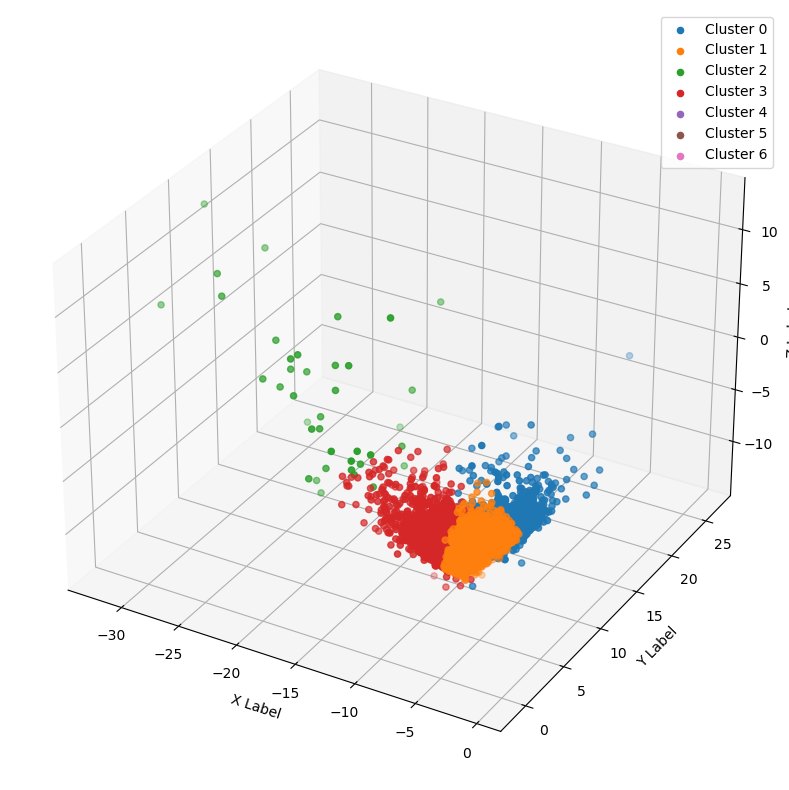

In [39]:
fig = plt.figure()
fig.set_size_inches(15, 10)
ax = fig.add_subplot(projection='3d')

for c in range(7):
    X = data_pca_3.filter(data_pca_3.prediction == c).select("pca3_features").collect()
    xs = [a.pca3_features[0] for a in X]
    ys = [a.pca3_features[1] for a in X]
    zs = [a.pca3_features[2] for a in X]
    ax.scatter(xs, ys, zs, label='Cluster {}'.format(c))

# ax.scatter(xs, ys, zs, c=c, label=c)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.legend(loc="upper right")
# plt.legend([0, 1, 2, 3, 4, 5, 6])
# plt.legend([0, 1, 2, 3, 4, 5, 6], loc="upper right")

plt.show()

In [40]:
data_clusters.groupby('prediction').count().sort('prediction').show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0| 1468|
|         1| 5303|
|         2|   39|
|         3| 1826|
+----------+-----+



## Modelagem de Random Forest

### Grid Search

In [41]:
cv_data = data_clusters.withColumn('cluster', col('prediction').cast(DoubleType()))
cv_data.printSchema()

root
 |-- CUST_ID: string (nullable = true)
 |-- BALANCE: double (nullable = true)
 |-- BALANCE_FREQUENCY: double (nullable = true)
 |-- PURCHASES: double (nullable = true)
 |-- ONEOFF_PURCHASES: double (nullable = true)
 |-- INSTALLMENTS_PURCHASES: double (nullable = true)
 |-- CASH_ADVANCE: double (nullable = true)
 |-- PURCHASES_FREQUENCY: double (nullable = true)
 |-- ONEOFF_PURCHASES_FREQUENCY: double (nullable = true)
 |-- PURCHASES_INSTALLMENTS_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_TRX: integer (nullable = true)
 |-- PURCHASES_TRX: integer (nullable = true)
 |-- CREDIT_LIMIT: double (nullable = true)
 |-- PAYMENTS: double (nullable = true)
 |-- MINIMUM_PAYMENTS: double (nullable = true)
 |-- PRC_FULL_PAYMENT: double (nullable = true)
 |-- TENURE: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- standardized: vector (nullable = true)
 |-- pca_features: vector (nullable = true)
 |-- predict

In [42]:
clf = RandomForestClassifier(
                             featuresCol = 'features', 
                             labelCol = 'cluster',
                             predictionCol = 'prediction_rf'
                            )

In [43]:
paramGrid = ParamGridBuilder() \
    .addGrid(clf.numTrees, [x for x in np.linspace(start = 10, stop = 50, num = 2, dtype='int')]) \
    .addGrid(clf.maxDepth, [x for x in np.linspace(start = 5, stop = 25, num = 2, dtype='int')]) \
    .addGrid(clf.maxBins , [x for x in np.linspace(start = 2, stop = k_clusters, num = 2, dtype='int')]) \
    .addGrid(clf.impurity, ['gini', 'entropy']) \
    .build()

In [44]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction_rf', labelCol='cluster')

In [45]:
# Cross validator with random search
cv = CrossValidator(
                    estimator = clf, 
                    estimatorParamMaps = paramGrid, 
                    evaluator = evaluator,   
                    parallelism = 2
                   )

In [46]:
cvModel = cv.fit(cv_data)

In [47]:
cvModel.bestModel

RandomForestClassificationModel: uid=RandomForestClassifier_f1e05dc6713b, numTrees=50, numClasses=4, numFeatures=17

In [48]:
cvModel.explainParams()

"estimator: estimator to be cross-validated (current: RandomForestClassifier_f1e05dc6713b)\nestimatorParamMaps: estimator param maps (current: [{Param(parent='RandomForestClassifier_f1e05dc6713b', name='numTrees', doc='Number of trees to train (>= 1).'): 10, Param(parent='RandomForestClassifier_f1e05dc6713b', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 5, Param(parent='RandomForestClassifier_f1e05dc6713b', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 2, Param(parent='RandomForestClassifier_f1e05dc6713b', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini'): 'gini'}, {Param(parent='RandomForestClassifier_f1e05dc6713b', name='numTrees', doc='Number of trees to train (>= 1).'): 10, Param(parent='